# Load Model

In [27]:
import openvino as ov

core = ov.Core()

model = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model = core.compile_model(model=model, device_name="CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

print("Input shape:", input_layer.shape)
print("Output shape:", output_layer.shape)

Input shape: [1,3,384,672]
Output shape: [1,1,200,7]


# Preprocess New Input Data

### call Image

(2845, 5050, 3)
(569, 1010, 3)


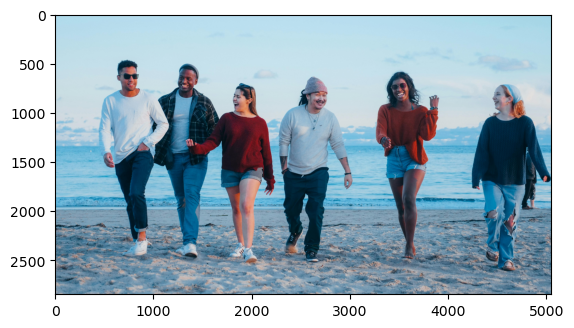

In [28]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("data/people.jpg")
print(image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

image_height, image_width, image_channels=image.shape
image = cv2.resize(image, (int(image_width/5), int(image_height/5)))
print(image.shape)

cv2.imshow("Image", image)
cv2.waitKey()
cv2.destroyAllWindows()

# Preprocess Data

In [29]:
import numpy as np

def preprocess(image):
    N, input_channels, input_height, input_width = input_layer.shape

    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np.expand_dims(transposed_image, 0)

    return input_image, resized_image

In [30]:
input_image, resized_image = preprocess(image)

print(image.shape)
print(np.shape(input_image))

(569, 1010, 3)
(1, 3, 384, 672)


# Run Inference

In [31]:
results = compiled_model([input_image])[output_layer]

In [32]:
print(results.shape)

(1, 1, 200, 7)


In [33]:
print(np.round(results[-1], 2))

[[[0.   1.   1.   ... 0.19 0.17 0.27]
  [0.   1.   1.   ... 0.23 0.71 0.31]
  [0.   1.   1.   ... 0.27 0.55 0.34]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]]


# Postprocess

In [45]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:,2]
    boxes = results[:, -4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]

    image_h, image_w, image_channels = image.shape
    
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores
    

In [46]:
confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
print(face_boxes)

[[131 108 169 152]
 [685 131 719 174]
 [515 156 554 195]
 [363 154 393 197]
 [253 113 286 155]
 [893 154 924 198]]


In [36]:
print(scores)

[1.         1.         1.         0.99999475 0.9999534  0.9737781 ]


In [37]:
def draw_faceboxes(image, face_boxes, scores):
    
    show_image = image.copy()
    
    for i in range(len(face_boxes)):
    
        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(0, 200, 0), thickness=2)
    
    return show_image

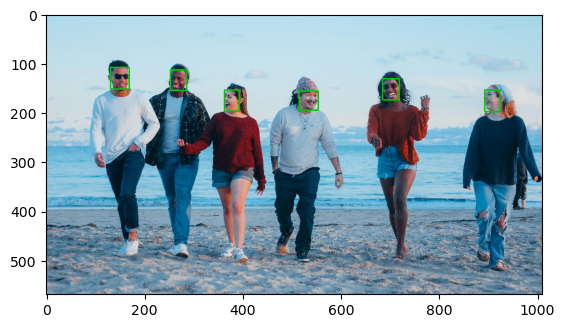

In [38]:
show_image = draw_faceboxes(image, face_boxes, scores)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

In [47]:
cv2.imshow("Face Detection", show_image)
cv2.waitKey()
cv2.destroyAllWindows()